### Env

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,r2_score,precision_score,recall_score, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import shap

In [3]:
index = pd.read_csv("../data/fmri_derived/dfcs/all_dfcs_flattened_index.csv",index_col=0)
clusters = pd.read_csv("../data/fmri_derived/dfcs/all_dfcs_flattened_clusters.csv",index_col=0)
latent_features = pd.read_csv("../data/fmri_derived/dfcs/latent_representations_5.csv",index_col=0)
participants = pd.read_csv("../data/fmri_datasets/ds002837/participants.tsv",sep="\t")

### Feature Engineering

In [4]:
# Info sub
participants['sub'] = range(1,87)
participants = participants[participants['sub'] != 49] # ta corrompido
participants = participants.set_index("sub")
le = LabelEncoder()
participants['sex_enc'] = le.fit_transform(participants['sex'])
participants['movie_enc'] = le.fit_transform(participants['task'])

# FC sub
latent_mean = pd.concat([index["sub"],latent_features], axis=1).groupby('sub').mean()
latent_mean = latent_mean.rename(columns={'0':'latent_0_mean','1':'latent_1_mean','2':'latent_2_mean','3':'latent_3_mean','4':'latent_4_mean'})
latent_std = pd.concat([index["sub"],latent_features], axis=1).groupby('sub').std()
latent_std = latent_std.rename(columns={'0':'latent_0_std','1':'latent_1_std','2':'latent_2_std','3':'latent_3_std','4':'latent_4_std'})
df_sub = pd.concat([participants,latent_mean,latent_std],axis=1)
df_sub = df_sub.reset_index()
df_sub

,sub,participant_id,age,sex,task,sex_enc,movie_enc,latent_0_mean,latent_1_mean,latent_2_mean,latent_3_mean,latent_4_mean,latent_0_std,latent_1_std,latent_2_std,latent_3_std,latent_4_std
0,1,sub-1,23,M,500daysofsummer,1,1,3.162638,5.925589,-1.143858,2.218207,1.597501,0.672776,1.466371,0.219248,0.385372,0.217499
1,2,sub-2,25,F,500daysofsummer,0,1,3.776082,7.476023,-1.391697,2.525142,1.763023,0.706343,1.448168,0.211497,0.341935,0.227944
2,3,sub-3,23,M,500daysofsummer,1,1,5.513047,11.194756,-2.387877,3.538861,2.157614,0.613294,1.305417,0.373405,0.408643,0.167078
3,4,sub-4,23,M,500daysofsummer,1,1,3.643506,7.227500,-1.403765,2.490345,1.753710,0.670784,1.404699,0.204378,0.316438,0.205506
4,5,sub-5,22,F,500daysofsummer,0,1,3.108110,6.173529,-1.275677,2.244006,1.528520,0.515597,1.073678,0.147323,0.269487,0.175569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,82,sub-82,50,M,12yearsaslave,1,0,3.890203,7.586806,-1.391126,2.584283,1.752000,0.693899,1.428307,0.280200,0.360941,0.192249
81,83,sub-83,18,F,12yearsaslave,0,0,3.588369,7.173983,-1.447553,2.458704,1.691992,0.813940,1.706542,0.283794,0.419527,0.256105
82,84,sub-84,22,F,12yearsaslave,0,0,3.380682,6.653613,-1.351115,2.315013,1.650946,0.812360,1.727297,0.257064,0.429653,0.243600
83,85,sub-85,23,F,12yearsaslave,0,0,4.585980,9.072399,-1.744588,2.977025,1.947385,0.811595,1.681783,0.408070,0.469333,0.212813


In [5]:
# Features of Now
df_moment = pd.concat([index,clusters,latent_features],axis=1)
df_moment = df_moment.rename(columns={'KMeans_5_5':'brain_state_now','0':'latent_0_now','1':'latent_1_now','2':'latent_2_now','3':'latent_3_now','4':'latent_4_now'})
df_moment = df_moment[['start','sub','brain_state_now','latent_0_now','latent_1_now','latent_2_now','latent_3_now','latent_4_now']]

# Moving brain states to create previous
for lag in range(1,11):
    df_moment[f'brain_state_previous_{lag}'] = df_moment.groupby(['sub'])["brain_state_now"].shift(lag)  
    
# Moving average latent
for latent in ['latent_0_now','latent_1_now','latent_2_now','latent_3_now','latent_4_now']:
    df_moment[f'{latent[:-4]}_mov_avg'] = df_moment.groupby(['sub'])[latent].transform(lambda x: x.rolling(window=10).mean())
    df_moment[f'{latent[:-4]}_mov_std'] = df_moment.groupby(['sub'])[latent].transform(lambda x: x.rolling(window=10).std())

# Moving brain states to create future/target
for lag in range(1,60):
    df_moment[f'brain_state_future_{lag}'] = df_moment.groupby(['sub'])["brain_state_now"].shift(-lag)  
    
df_moment.head(10)

,start,sub,brain_state_now,latent_0_now,latent_1_now,latent_2_now,latent_3_now,latent_4_now,brain_state_previous_1,brain_state_previous_2,...,brain_state_future_50,brain_state_future_51,brain_state_future_52,brain_state_future_53,brain_state_future_54,brain_state_future_55,brain_state_future_56,brain_state_future_57,brain_state_future_58,brain_state_future_59
0,0,1,1,4.120012,7.615789,-1.354158,2.959522,2.059166,NaN,NaN,...,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,75,1,2,3.890500,7.310535,-1.369051,2.829891,1.954685,1.0,NaN,...,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,225,1,4,2.520236,4.342128,-0.882425,1.766249,1.420300,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,300,1,4,2.589759,4.593969,-0.957129,1.862471,1.436314,4.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,375,1,4,2.417389,4.026599,-0.818179,1.671766,1.416189,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
5,450,1,4,2.529787,4.304999,-0.892219,1.788492,1.460401,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
6,525,1,4,2.413943,3.974459,-0.824190,1.686797,1.418958,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,600,1,4,2.279178,3.704214,-0.796861,1.593387,1.341033,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8,675,1,4,2.519513,4.268560,-0.875378,1.780132,1.420466,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
9,750,1,4,2.366591,3.967802,-0.825102,1.654887,1.341678,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN


In [6]:
df = df_sub.merge(df_moment,left_on="sub", right_on="sub")
df.columns

Index(['sub', 'participant_id', 'age', 'sex', 'task', 'sex_enc', 'movie_enc',
       'latent_0_mean', 'latent_1_mean', 'latent_2_mean',
       ...
       'brain_state_future_50', 'brain_state_future_51',
       'brain_state_future_52', 'brain_state_future_53',
       'brain_state_future_54', 'brain_state_future_55',
       'brain_state_future_56', 'brain_state_future_57',
       'brain_state_future_58', 'brain_state_future_59'],
      dtype='object', length=103)

### Model Training, Evaluation and Explainability

- Features

In [7]:
participant_features = ['age', 'sex_enc', 'movie_enc']#, 
                        # tem um pouco de vazamento de dados nessas features
                        #'latent_0_mean', 'latent_1_mean', 'latent_2_mean', 'latent_0_std', 'latent_1_std', 'latent_2_std','latent_3_mean','latent_3_std','latent_4_mean','latent_4_std']]
now_features = ['brain_state_now', 'latent_0_now', 'latent_1_now', 'latent_2_now','latent_3_now','latent_4_now']
previous_brain_states = ['brain_state_previous_1', 'brain_state_previous_2',
                       'brain_state_previous_3', 'brain_state_previous_4',
                       'brain_state_previous_5', 'brain_state_previous_6',
                       'brain_state_previous_7', 'brain_state_previous_8',
                       'brain_state_previous_9', 'brain_state_previous_10']
previous_latents = ['latent_0_mov_avg', 'latent_0_mov_std', 'latent_1_mov_avg','latent_1_mov_std', 'latent_2_mov_avg', 'latent_2_mov_std',
                    'latent_3_mov_avg','latent_3_mov_std','latent_4_mov_avg','latent_4_mov_std']

- Performance tests with Controls

In [8]:
def shuffle_test(df, lag_target):
    # Split
    target = [f'brain_state_future_{lag_target}']
    df_test = df[participant_features + now_features + previous_brain_states + previous_latents + target].dropna()
    X = df_test.drop(columns=target)
    y = df_test[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    y_test = y_test.sample(frac=1).reset_index(drop=True) #Alteration
    # Model
    model = LGBMClassifier(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    f1 = round(f1_score(y_test, y_pred, average='macro'),2)
    return f1

def copy_last_Brain_State_test(df, lag_target):
    # Split
    target = [f'brain_state_future_{lag_target}']
    df_test = df[participant_features + now_features + previous_brain_states + previous_latents + target].dropna()
    X = df_test.drop(columns=target)
    y = df_test[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Model
    y_pred = X_test['brain_state_previous_1'] #Alteration
    f1 = round(f1_score(y_test, y_pred, average='macro'),2)
    return f1

def wrong_lag_test(df, lag_target, lag_train=4):
    # Split
    target = [f'brain_state_future_{lag_train}',f'brain_state_future_{lag_train+lag_target}'] #Alteration
    df_test = df[participant_features + now_features + previous_brain_states + previous_latents + target].dropna()
    X = df_test.drop(columns=target)
    y = df_test[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    y_train = y_train[f'brain_state_future_{lag_train}'] #Alteration
    y_test = y_test[f'brain_state_future_{lag_train+lag_target}'] #Alteration
    # Model
    model = LGBMClassifier(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    f1 = round(f1_score(y_test, y_pred, average='macro'),2)
    return f1

def correct_test(df, lag_target):
    # Split
    target = [f'brain_state_future_{lag_target}']
    df_test = df[participant_features + now_features + previous_brain_states + previous_latents + target].dropna()
    X = df_test.drop(columns=target)
    y = df_test[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Model
    model = LGBMClassifier(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    f1 = round(f1_score(y_test, y_pred, average='macro'),2)
    return f1

def subset_features_test(df, lag_target,
                         _participant_features = 1,
                         _now_features = 1,
                         _previous_brain_states = 1,
                         _previous_latents = 1):
    # Subset Features
    ##########################################################################
    if _participant_features :
        participant_features = ['age', 'sex_enc', 'movie_enc']#, 
                        # tem um pouco de vazamento de dados nessas features
                        #'latent_0_mean', 'latent_1_mean', 'latent_2_mean', 'latent_0_std', 'latent_1_std', 'latent_2_std','latent_3_mean','latent_3_std','latent_4_mean','latent_4_std']]
    else:
        participant_features = []
    ##########################################################################
    if _previous_brain_states:
        previous_brain_states = ['brain_state_previous_1', 'brain_state_previous_2',
                       'brain_state_previous_3', 'brain_state_previous_4',
                       'brain_state_previous_5', 'brain_state_previous_6',
                       'brain_state_previous_7', 'brain_state_previous_8',
                       'brain_state_previous_9', 'brain_state_previous_10']
    else:
        previous_brain_states = []
    ##########################################################################
    if _now_features:
        now_features = ['brain_state_now', 'latent_0_now', 'latent_1_now', 'latent_2_now','latent_3_now','latent_4_now']
    else:
        now_features = []
    ##########################################################################
    if _previous_latents:
        previous_latents = ['latent_0_mov_avg', 'latent_0_mov_std', 'latent_1_mov_avg','latent_1_mov_std', 'latent_2_mov_avg', 'latent_2_mov_std',
                    'latent_3_mov_avg','latent_3_mov_std','latent_4_mov_avg','latent_4_mov_std']
    else:
        previous_latents = []
    ##########################################################################
    # Split
    target = [f'brain_state_future_{lag_target}']
    df_test = df[participant_features + now_features + previous_brain_states + previous_latents + target].dropna()
    X = df_test.drop(columns=target)
    y = df_test[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Model
    model = LGBMClassifier(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    f1 = round(f1_score(y_test, y_pred, average='macro'),2)
    return f1

prediction_metrics = []
for lag_target in range(1,56):

    prediction_metrics.append([lag_target, 
                               correct_test(df, lag_target),
                               shuffle_test(df, lag_target), 
                               copy_last_Brain_State_test(df, lag_target), 
                               wrong_lag_test(df, lag_target),
                               subset_features_test(df, lag_target, _participant_features = 0),
                               subset_features_test(df, lag_target, _now_features = 0),
                               subset_features_test(df, lag_target, _previous_brain_states = 0),
                               subset_features_test(df, lag_target, _previous_latents = 0),
                               subset_features_test(df, lag_target, _previous_latents = 0, _previous_brain_states = 0)
                               ])
    
df_metrics = pd.DataFrame(prediction_metrics).rename(columns={0:"forecast lag",
                                                              1:"Estimator: Correct",
                                                              2:"Estimator: Shuffled",
                                                              3:"Estimator: Copy last Brain State",
                                                              4:"Estimator: Wrong Prediction Lag (+5min)",
                                                              5:"Estimator: No participant features",
                                                              6:"Estimator: No now features",
                                                              7:"Estimator: No previous brain states features",
                                                              8:"Estimator: No previous latents features",
                                                              9:"Estimator: No previous brain states and latents features"
                                                             }).set_index("forecast lag")


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [14]:
df_metrics['Estimator: Correct'].mean()

0.6269090909090909

In [15]:
df_metrics['Estimator: Correct'].std()

0.02794655794565946

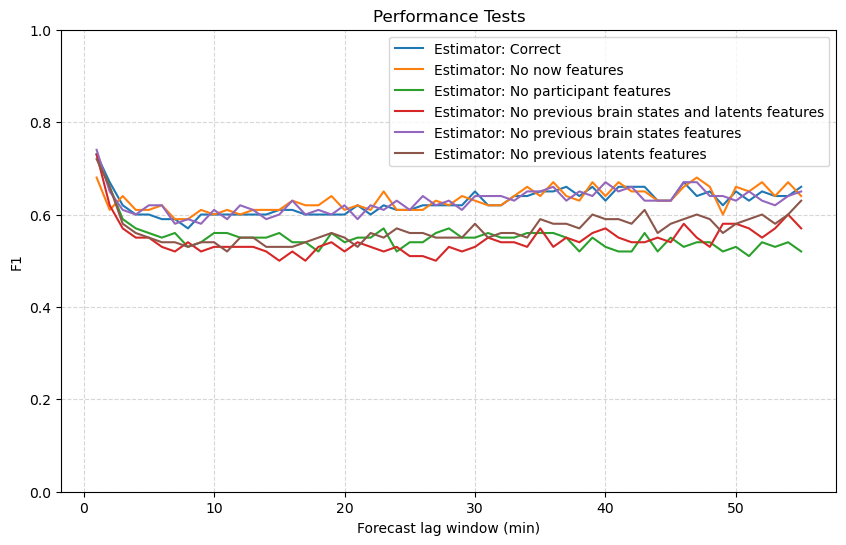

In [9]:
df_dummy = df_metrics[df_metrics.columns.difference(df_metrics.columns[1:4])]
plt.figure(figsize=(10, 6))
plt.plot(df_dummy, label=df_dummy.columns)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1) 
plt.title("Performance Tests")
plt.ylabel("F1")
plt.xlabel("Forecast lag window (min)")
plt.show()
#plt.savefig("../data/fmri_derived/dfcs/Forecast_Outputs/Performance_Tests.png", dpi=100)
#plt.close()

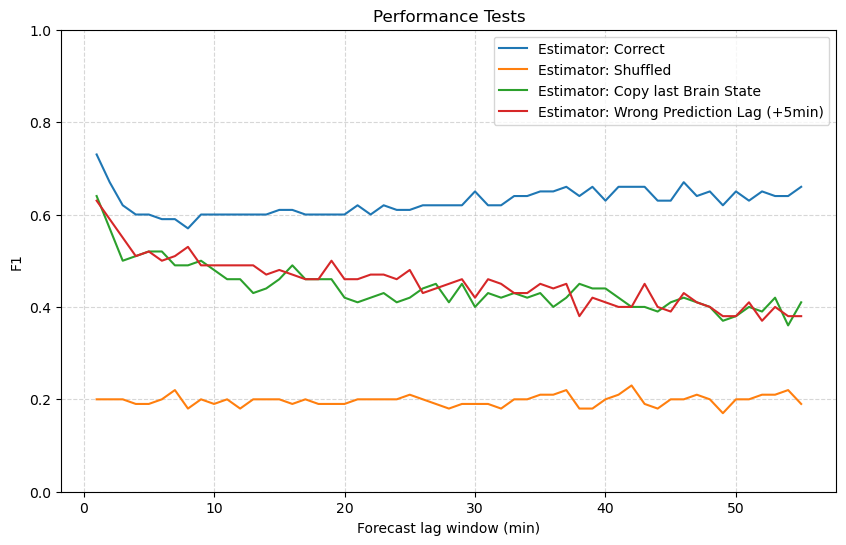

In [10]:
df_dummy = df_metrics[df_metrics.columns[:4]]
plt.figure(figsize=(10, 6))
plt.plot(df_dummy, label=df_dummy.columns)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1) 
plt.title("Performance Tests")
plt.ylabel("F1")
plt.xlabel("Forecast lag window (min)")
plt.show()
#plt.savefig("../data/fmri_derived/dfcs/Forecast_Outputs/Performance_Tests.png", dpi=100)
#plt.close()

- Modelo Oficial

/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


f1: 0.65 | precision: 0.65 | recall: 0.65


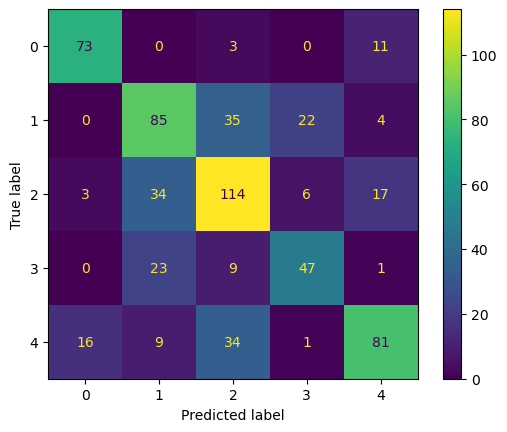

In [11]:
#Split
target = [f'brain_state_future_50']
df_test = df[participant_features + now_features + previous_brain_states + previous_latents + target].dropna()
X = df_test.drop(columns=target)
y = df_test[target]

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LGBMClassifier(verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Plot Confusion Matrix
f1 = round(f1_score(y_test, y_pred, average='macro'),2)
precision = round(precision_score (y_test, y_pred, average='macro'),2)
recall = round(recall_score (y_test, y_pred, average='macro'),2)
print(f'f1: {f1} | precision: {precision} | recall: {recall}')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
#plt.savefig("../data/fmri_derived/dfcs/Forecast_Outputs/Confusion_Matrix_lag4.png", dpi=100)
#plt.close()

In [29]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

100%|===================| 3126/3140 [01:29<00:00]        

In [30]:
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.savefig("../data/fmri_derived/dfcs/Forecast_Outputs/Shap_Summary_lag40.png", dpi=100)
plt.close()